In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import sys
sys.path.insert(0, '/home/jr0th/github/segmentation/code/')
import helper.model_builder
import helper.metrics

import skimage.io

import numpy as np

import time

import keras

# build session running on a specific GPU
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "2"
session = tf.Session(config = configuration)

keras.backend.set_session(session)

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
img_load_pattern = '/home/jr0th/github/segmentation/data/BBBC022_hand_200/test/x/all/*.png'

# uncomment the following line to use full images instead of crops
img_load_pattern = '/home/jr0th/github/segmentation/data/BBBC022_hand_200/test/x_big/*.png'

# use latest checkpoint
weights_path = '/home/jr0th/github/segmentation/checkpoints/checkpoint_boundary_4_generator.hdf5'

# get images
images = skimage.io.imread_collection(img_load_pattern).concatenate()

# assume that images are all the same shape
n_images = images.shape[0]
dim1 = images.shape[1]
dim2 = images.shape[2]

# build model and load weights
model = helper.model_builder.get_model_1_class(dim1, dim2)

model.load_weights(weights_path)

/home/jr0th/github/segmentation/code/helper/model_builder.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/jr0th/github/segmentation/code/helper/model_builder.py:27: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jr0th/github/segmentation/code/helper/model_builder.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/jr0th/github/segmentation/code/helper/model_builder.py:33: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jr0th/github/segmentation/code/helper/mode

# TEST INFERENCE AND POST PROCESSING TIME

Heating up GPU now.
GPU is hot now.
Iteration 1 of 100


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration 2 of 100
Iteration 3 of 100
Iteration 4 of 100
Iteration 5 of 100
Iteration 6 of 100
Iteration 7 of 100
Iteration 8 of 100
Iteration 9 of 100
Iteration 10 of 100
Iteration 11 of 100
Iteration 12 of 100
Iteration 13 of 100
Iteration 14 of 100
Iteration 15 of 100
Iteration 16 of 100
Iteration 17 of 100
Iteration 18 of 100
Iteration 19 of 100
Iteration 20 of 100
Iteration 21 of 100
Iteration 22 of 100
Iteration 23 of 100
Iteration 24 of 100
Iteration 25 of 100
Iteration 26 of 100
Iteration 27 of 100
Iteration 28 of 100
Iteration 29 of 100
Iteration 30 of 100
Iteration 31 of 100
Iteration 32 of 100
Iteration 33 of 100
Iteration 34 of 100
Iteration 35 of 100
Iteration 36 of 100
Iteration 37 of 100
Iteration 38 of 100
Iteration 39 of 100
Iteration 40 of 100
Iteration 41 of 100
Iteration 42 of 100
Iteration 43 of 100
Iteration 44 of 100
Iteration 45 of 100
Iteration 46 of 100
Iteration 47 of 100
Iteration 48 of 100
Iteration 49 of 100
Iteration 50 of 100
Iteration 51 of 100
Iteratio

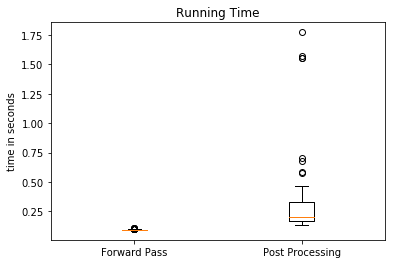

In [3]:
# label = 'PATCH'
# label = 'PATCH_thresh'
# label = 'PATCH_remove_small'
# label = 'PATCH_thresh_remove_small'

# label = 'FULL'
# label = 'FULL_thresh'
# label = 'FULL_remove_small'
label = 'FULL_thresh_remove_small'

N = 100

time_inf = np.zeros(N)
time_pp = np.zeros(N)

batch_size = 10

print('Heating up GPU now.')

# heat up GPU
for i in range(10):
    model.predict(np.zeros((batch_size, dim1, dim2, 1)), batch_size=batch_size)

print('GPU is hot now.')

for i in range(N):
    
    print('Iteration', i+1, 'of', N)
    
    # get random image
    img = images[np.random.randint(0, n_images)]

    # preprocessing
    img_rescaled = np.reshape(img / 255, (-1, dim1, dim2, 1))

    # inference
    start_inf = time.time()
    outline_pred = model.predict(img_rescaled)
    end_inf = time.time()

    time_inf[i] = end_inf - start_inf

    # postprocessing
    outline_pred = outline_pred.squeeze()
    start_pp = time.time()
    contour = helper.metrics.probmap_to_contour(outline_pred)
    segmentation = helper.metrics.contour_to_label(contour, img_rescaled)
    end_pp = time.time()

    time_pp[i] = end_pp - start_pp
    
    # visualize
    visualize = False
    if(visualize):
        plt.imshow(img)
        plt.colorbar()
        plt.title('Image')
        plt.show()

        plt.imshow(outline_pred)
        plt.colorbar()
        plt.title('Outline Probability Map')
        plt.show()

        plt.imshow(contour)
        plt.colorbar()
        plt.title('Thresholded Contours')
        plt.show()

        plt.imshow(segmentation)
        plt.colorbar()
        plt.title('Predicted Segmentation')
        plt.show()

plt.boxplot([time_inf[1:], time_pp[1:]], labels=['Forward Pass', 'Post Processing'])
plt.title('Running Time')
plt.ylabel('time in seconds')
plt.savefig('inf_pp_time_' + label + '.svg', format='svg')

np.save('inf_pp_time_' + label + '.npy',[time_inf, time_pp])

print('Mean time for inference: ', np.mean(time_inf))
print('Mean time for inference: ', np.mean(time_pp))

# TEST DEPENDENCY ON BATCH SIZE

In [ ]:
max_n_images = 15
batch_size = 5

N = 100

runtimes_per_image = np.zeros((N, max_n_images))

print('Heating up GPU now.')

# heat up GPU
for i in range(10):
    model.predict(np.zeros((batch_size, dim1, dim2, 1)), batch_size=batch_size)

print('GPU is hot now.')

# loop over iterations
for i in range(N):
    
    # loop over number of images
    for n_images in range(1, max_n_images + 1):

        # prepare data
        data = np.zeros((n_images, dim1, dim2, 1))
        for j in range(n_images):
            # get random image
            data[j,:,:,0] = images[j]

        # preprocessing
        data = data / 255

        # inference
        time_inf = 0
        start_inf = time.time()
        outline_pred = model.predict(data, batch_size=batch_size)
        end_inf = time.time()

        time_inf = end_inf - start_inf

        # visualize
        visualize = False
        if(visualize):
            plt.imshow(outline_pred[0].squeeze())
            plt.show()

        runtimes_per_image[i,n_images-1] = time_inf / n_images
        print('Time for inference per image:', np.round(runtimes_per_image[i, n_images-1], decimals=2), 'with', n_images, 'samples')

Heating up GPU now.
GPU is hot now.
Time for inference per image: 0.09 with 1 samples
Time for inference per image: 0.09 with 2 samples
Time for inference per image: 0.09 with 3 samples
Time for inference per image: 0.09 with 4 samples
Time for inference per image: 0.09 with 5 samples
Time for inference per image: 0.09 with 6 samples
Time for inference per image: 0.09 with 7 samples
Time for inference per image: 0.09 with 8 samples
Time for inference per image: 0.09 with 9 samples
Time for inference per image: 0.1 with 10 samples
Time for inference per image: 0.09 with 11 samples
Time for inference per image: 0.09 with 12 samples
Time for inference per image: 0.1 with 13 samples
Time for inference per image: 0.1 with 14 samples
Time for inference per image: 0.09 with 15 samples
Time for inference per image: 0.1 with 1 samples
Time for inference per image: 0.09 with 2 samples
Time for inference per image: 0.1 with 3 samples
Time for inference per image: 0.09 with 4 samples
Time for infe

In [ ]:
plt.boxplot(runtimes_per_image[1:])
plt.title('Running Time')
plt.ylabel('inference time per image in seconds')
plt.xlabel('data set size (batch size = '+str(batch_size)+')')
plt.savefig('runtime_batch_size.svg', format='svg')

np.save('runtimes_per_image.npy', runtimes_per_image)

# HELPER TO GET MEAN VALUES

In [ ]:
data = np.load('./inf_pp_time_PATCH_thresh_remove_small.npy')
np.mean(data[:,1:], axis=1)